In [ ]:
import os
import requests
from urllib.parse import urljoin, unquote
from bs4 import BeautifulSoup
import re

BASE_URL = "https://neat-cities-clean.loca.lt"

def list_files_recursive(base_url, path=""):
    url = urljoin(base_url, path)
    print(f"📂 Scanning: {url}")
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
    except Exception as e:
        print(f"❌ Failed to access: {url} — {e}")
        return []

    soup = BeautifulSoup(r.text, 'html.parser')
    files = []

    for link in soup.find_all('a', href=True):
        href = link['href']
        if href in ['../', './']:
            continue

        name = unquote(href)
        full_path = os.path.join(path, name)

        if href.endswith('/'):
            # Go deeper into subdirectory
            files += list_files_recursive(base_url, full_path)
        else:
            files.append(full_path)

    return files

files = list_files_recursive(BASE_URL, "data/")


for file_path in files:
    file_url = urljoin(BASE_URL, file_path)
    print(f"⬇️ Downloading: {file_url}")
    try:
        r = requests.get(file_url, timeout=30)
        r.raise_for_status()
    except Exception as e:
        print(f"❌ Failed to download {file_url}: {e}")
        continue

    local_path = os.path.join("dataset", file_path)
    os.makedirs(os.path.dirname(local_path), exist_ok=True)
    with open(local_path, "wb") as f:
        f.write(r.content)

📂 Scanning: https://neat-cities-clean.loca.lt/data/
📂 Scanning: https://neat-cities-clean.loca.lt/data/Forest Recordings/
📂 Scanning: https://neat-cities-clean.loca.lt/data/Parsed_Capuchinbird_Clips/
📂 Scanning: https://neat-cities-clean.loca.lt/data/Parsed_Not_Capuchinbird_Clips/
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_00.mp3
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_01.mp3
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_02.mp3
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_03.mp3
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_04.mp3
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_05.mp3
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_06.mp3
⬇️ Downloading: https://neat-cities-clean.loca.lt/data/Forest Recordings/recording_07.mp

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa
import tensorflow_io as tfio
import numpy as np
import os

In [ ]:
def load_wav_16k_mono(filename):
    audio, _ = librosa.load(filename, sr=16000, mono=True)
    return tf.convert_to_tensor(audio, dtype=tf.float32)

In [ ]:
wave = load_wav_16k_mono("/content/dataset/data/Parsed_Capuchinbird_Clips/XC3776-3.wav")
nwave = load_wav_16k_mono("/content/dataset/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav")

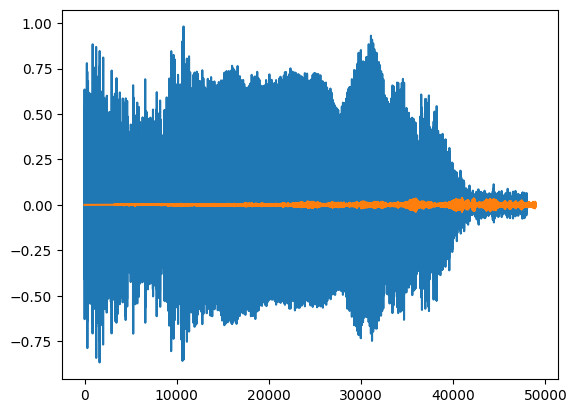

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS= "/content/dataset/data/Parsed_Capuchinbird_Clips"
NEG ="/content/dataset/data/Parsed_Not_Capuchinbird_Clips"

In [ ]:
POS = "/content/dataset/data/Parsed_Capuchinbird_Clips"
NEG = "/content/dataset/data/Parsed_Not_Capuchinbird_Clips"

# Create tf.data.Datasets for file paths
pos_files = tf.data.Dataset.list_files(f"{POS}/*.wav", shuffle=True)
neg_files = tf.data.Dataset.list_files(f"{NEG}/*.wav", shuffle=True)

# Zip with labels: 1 for capuchinbird, 0 for not
positives = pos_files.map(lambda x: (x, tf.constant(1)))
negatives = neg_files.map(lambda x: (x, tf.constant(0)))

# Combine datasets
data = positives.concatenate(negatives)


In [ ]:
def load_wav_16k_mono_py(filepath):
    filepath = filepath.numpy().decode("utf-8")  # convert Tensor to Python string
    waveform, _ = librosa.load(filepath, sr=16000, mono=True)
    return waveform

In [ ]:
lengths=[]
base_path = "/content/dataset/data/Parsed_Capuchinbird_Clips"

for file in os.listdir(base_path):
    if file.endswith(".wav"):
        full_path = os.path.join(base_path, file)
        tensor_wave = load_wav_16k_mono(full_path)
        lengths.append(len(tensor_wave))


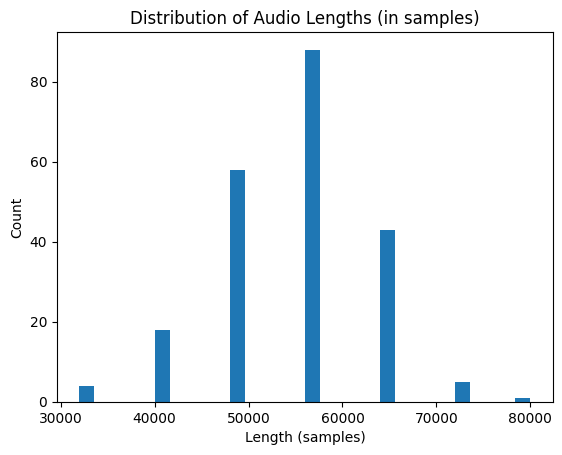

In [ ]:
import matplotlib.pyplot as plt

plt.hist(lengths, bins=30)
plt.title("Distribution of Audio Lengths (in samples)")
plt.xlabel("Length (samples)")
plt.ylabel("Count")
plt.show()

In [ ]:
tf.math.reduce_mean(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [ ]:
import librosa
import numpy as np
import tensorflow as tf

def preprocess(file_path, label):
    def load_and_convert(path):
        path = path.numpy().decode("utf-8")
        y, _ = librosa.load(path, sr=16000, mono=True)

        mel = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=64)
        log_mel = librosa.power_to_db(mel)

        target_width = 150
        if log_mel.shape[1] < target_width:
            pad_width = target_width - log_mel.shape[1]
            log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)))
        else:
            log_mel = log_mel[:, :target_width]

        return log_mel.astype(np.float32)

    spectrogram = tf.py_function(func=load_and_convert, inp=[file_path], Tout=tf.float32)
    spectrogram.set_shape([64, 150])

    return spectrogram, label


In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

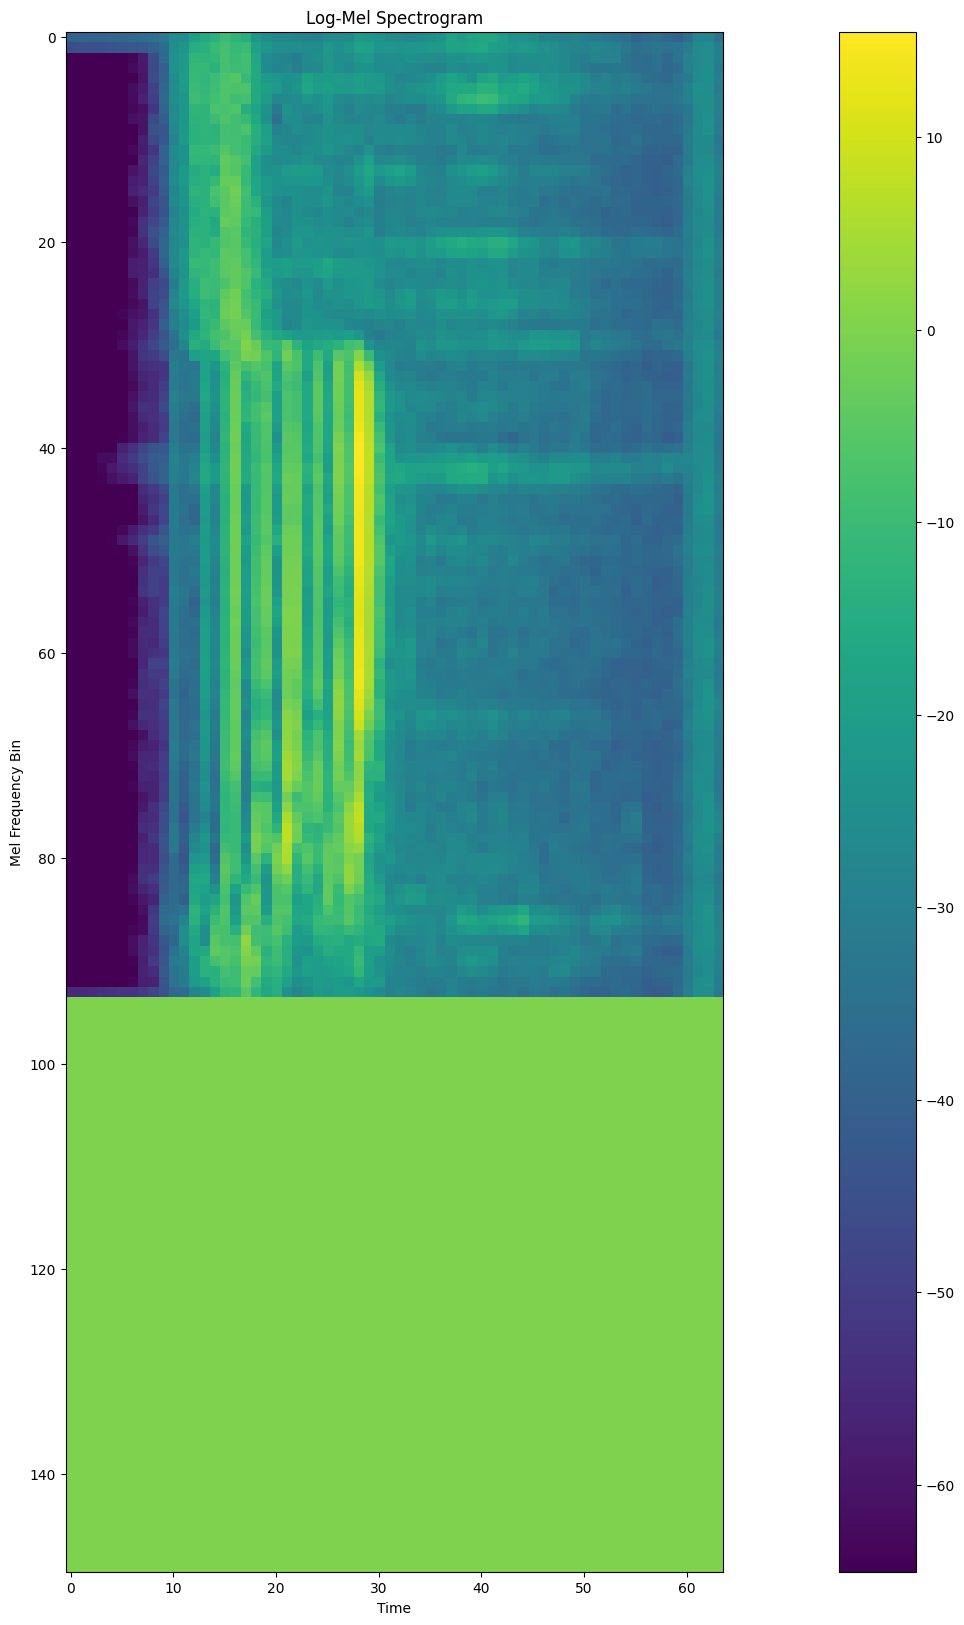

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram))
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bin")
plt.colorbar()
plt.show()


In [ ]:
data = data.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(16)
data = data.prefetch(tf.data.AUTOTUNE)


In [ ]:
for spec_batch, label_batch in data.take(1):
    print("Spec batch shape:", spec_batch.shape)
    print("Label batch shape:", label_batch.shape)

Spec batch shape: (16, 64, 150)
Label batch shape: (16,)


In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(64, 150, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 148, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 146, 16)    │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 140160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    17,940,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,943,217 (68.45 MB)

 Trainable params: 17,943,217 (68.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 483ms/step - loss: 54.1936 - precision: 0.6381 - recall: 0.6584 - val_loss: 0.2099 - val_precision: 0.9286 - val_recall: 1.0000
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 436ms/step - loss: 0.4806 - precision: 0.9495 - recall: 0.9989 - val_loss: 7.5749e-06 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 439ms/step - loss: 1.7591e-07 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.8656e-09 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 438ms/step - loss: 0.0201 - precision: 1.0000 - recall: 0.9900 - val_loss: 5.4780e-06 - val_precision: 1.0000 - val_recall: 1.0000


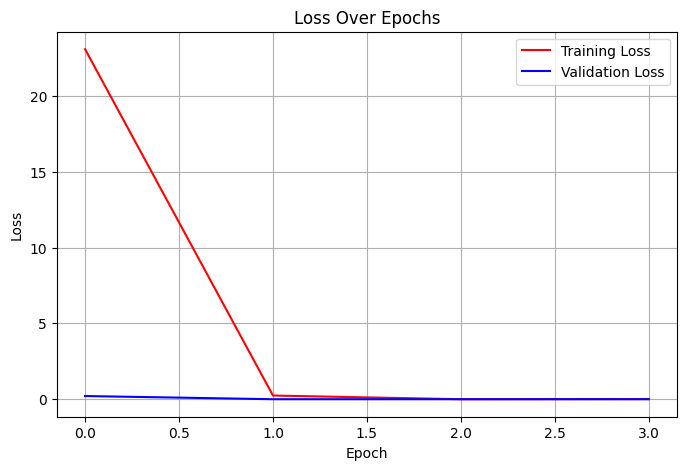

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(hist.history['loss'],'r', label='Training Loss')
plt.plot(hist.history['val_loss'],'b', label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

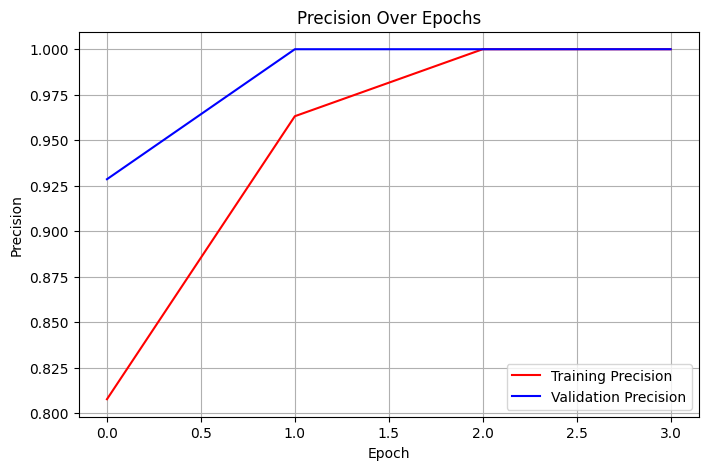

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(hist.history['precision'], 'r', label='Training Precision')
plt.plot(hist.history['val_precision'], 'b', label='Validation Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


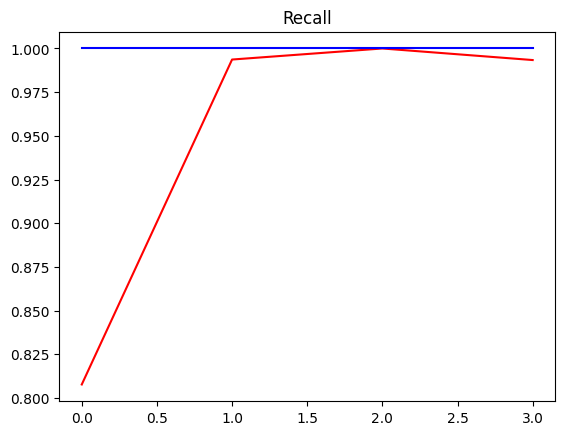

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
import librosa
import tensorflow as tf

def load_mp3_16k_mono(filepath):
    """Load an audio file, convert it to float32, and resample to 16kHz mono."""
    audio, _ = librosa.load(filepath, sr=16000, mono=True)
    return tf.convert_to_tensor(audio, dtype=tf.float32)

In [ ]:
mp3 = "/content/dataset/data/Forest Recordings/recording_00.mp3"

In [ ]:

wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

np.int32(4)

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

In [ ]:
import csv
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])